In [1]:
## Multi class classification with Linear SVC

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline


Using TensorFlow backend.


In [2]:
## Loading Data - labelled data :

data_1 = pd.ExcelFile('R2_RNN_Tranzact_Rohan_1_Regrouped_with_supplier.xlsx')
tranzact_data_1 = data_1.parse(0)

## Loading Data - un-labelled data:

data_2 = pd.ExcelFile('14Mar_Gorky_one_labelled.xlsx')
tranzact_data_new_1 = data_2.parse(0)

## Picking up required info from labelled data :

col = ['to_company_name', 'supplier_item_id.2', 'product', 'supplier']
tranzact_data_2 = tranzact_data_1[col]
tranzact_data_2.columns = ['OEM', 'item', 'product', 'supplier']

## Picking up required info from un-labelled data:

col = ['from_company_name', 'buyer_item_name', 'product', 'to_company_name']
tranzact_data_new_2 = tranzact_data_new_1[col]
tranzact_data_new_2.columns = ['OEM', 'item', 'product', 'supplier']

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from labelled Dat:

tranzact_data_cesare_international_1 = tranzact_data_2.loc[tranzact_data_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_2_revised = tranzact_data_2.drop(tranzact_data_cesare_international_1.index)
tranzact_data_cesare_international_1 = tranzact_data_cesare_international_1.reset_index(drop=True)
tranzact_data_2_revised = tranzact_data_2_revised.reset_index(drop=True)

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from unlabelled data :

tranzact_data_cesare_international_2 = tranzact_data_new_2.loc[tranzact_data_new_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_new_2_revised = tranzact_data_new_2.drop(tranzact_data_cesare_international_2.index)
tranzact_data_cesare_international_2 = tranzact_data_cesare_international_2.reset_index(drop=True)
tranzact_data_new_2_revised = tranzact_data_new_2_revised.reset_index(drop=True)



In [3]:
# Removing all 'Bonetti' & 'Waaree' supplier from both labelled and un-labelled data :

## First make Items in lower case and remove rows with any cell value = none :

tranzact_data_2_revised['item'] = tranzact_data_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_2_revised['product'] = tranzact_data_2_revised['product'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_2_revised['supplier'] = tranzact_data_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())
#tranzact_data_2_revised = tranzact_data_2_revised.dropna() ## remove rows with cell value none

tranzact_data_new_2_revised['item'] = tranzact_data_new_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_new_2_revised['product'] = tranzact_data_new_2_revised['product'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_new_2_revised['supplier'] = tranzact_data_new_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())
#tranzact_data_new_2_revised = tranzact_data_new_2_revised.dropna() ## remove rows with cell value none

# Removing string 'bonetti' and 'waaree' from supplier :

supplier_bonetti_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('waaree')]
supplier_bonetti_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('waaree')]

tranzact_data_3 = tranzact_data_2_revised.drop(supplier_bonetti_2.index) # 'bonetti' removed
tranzact_data_3 = tranzact_data_3.drop(supplier_waaree_2.index)   # 'waaree' removed
tranzact_data_new_3 = tranzact_data_new_2_revised.drop(supplier_bonetti_new_2.index)
tranzact_data_new_3 = tranzact_data_new_3.drop(supplier_waaree_new_2.index)

tranzact_data_3 = tranzact_data_3.reset_index(drop=True)
tranzact_data_new_3 = tranzact_data_new_3.reset_index(drop=True)

# Merging two data frames :

tranzact_data_combined = pd.concat([tranzact_data_3, tranzact_data_new_3], axis=0, ignore_index=True)

# Removing duplicate (item + supplier) combinations :

tranzact_data_combined['find_duplicate'] = tranzact_data_combined['item'].map(str) + \
                                            tranzact_data_combined['supplier'].map(str)

tranzact_data_combined.drop_duplicates(subset='find_duplicate', keep = 'first', inplace = True)
tranzact_data_combined = tranzact_data_combined.reset_index(drop=True)


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [252]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/18_04_test_1.xlsx')

In [6]:
## cleaning the data

pd.options.mode.chained_assignment = None

## Join all hyphaned words :

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'([a-z])-([a-z])', r'\1\2')
tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'([0-9])-([a-z])', r'\1\2')

## Removing underscores '_':

under_score = ['_']

for i in under_score:
    
    tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(i," ")

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\W',' ')   ## remove puntuations

## joinning consecutive single letters - SS:

s_s_list = pd.DataFrame()
s_s_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[s]\s+\b[s]\b')    
s_s_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[s]\s+\b[s]\b')].index.values
s_s_list = s_s_list[s_s_list.astype(str)['item'] != '[]']
s_s_list['joined'] = s_s_list.item.apply(''.join)
s_s_list.joined = s_s_list.joined.str.replace(' ', '')

## joinning consecutive single letters - MS:

ms_list = pd.DataFrame()
ms_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[m]\s+\b[s]\b')    
ms_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[m]\s+\b[s]\b')].index.values
ms_list = ms_list[ms_list.astype(str)['item'] != '[]']
ms_list['joined'] = ms_list.item.apply(''.join)
ms_list.joined = ms_list.joined.str.replace(' ', '')

## joinning consecutive single letters - CI:

ci_list = pd.DataFrame()
ci_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[c]\s+\b[i]\b')    
ci_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[c]\s+\b[i]\b')].index.values
ci_list = ci_list[ci_list.astype(str)['item'] != '[]']
ci_list['joined'] = ci_list.item.apply(''.join)
ci_list.joined = ci_list.joined.str.replace(' ', '')

## joinning consecutive single letters - CS:

cs_list = pd.DataFrame()
cs_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[c]\s+\b[s]\b')    
cs_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[c]\s+\b[s]\b')].index.values
cs_list = cs_list[cs_list.astype(str)['item'] != '[]']
cs_list['joined'] = cs_list.item.apply(''.join)
cs_list.joined = cs_list.joined.str.replace(' ', '')

## substituting above cell in tranzact_data_combine :

for i in s_s_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[s]\s+\b[s]\b', s_s_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ms_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[m]\s+\b[s]\b', ms_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ci_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[c]\s+\b[i]\b', ci_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in cs_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[c]\s+\b[s]\b', cs_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]



In [254]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/18_04_test_2.xlsx')

In [257]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/18_04_test_3.xlsx')

In [7]:
# making list for joinning is with number(indian standards):
is_list = pd.DataFrame()
is_list['item'] = tranzact_data_combined['item'].str.findall(r'\b\is\s+\d+\b')
is_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\is\s+\d+\b')].index.values
is_list = is_list[is_list.astype(str)['item'] != '[]']
is_list['joined'] = is_list.item.apply(''.join)
is_list.joined = is_list.joined.str.replace(' ', '')

# making list for joinning en with number(en standards):
en_list = pd.DataFrame()
en_list['item'] = tranzact_data_combined['item'].str.findall(r'\b\en\s+\d+\b')
en_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\en\s+\d+\b')].index.values
en_list = en_list[en_list.astype(str)['item'] != '[]']
en_list['joined'] = en_list.item.apply(''.join)
en_list.joined = en_list.joined.str.replace(' ', '')
2,
# making list for joinning ss with number(ss standards):
ss_list = pd.DataFrame()
ss_list['item'] = tranzact_data_combined['item'].str.findall(r'\bs\w\s+\d{2,3}\b')
ss_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\bs\w\s+\d{2,3}\b')].index.values
ss_list = ss_list[ss_list.astype(str)['item'] != '[]']
ss_list['joined'] = ss_list.item.apply(''.join)
ss_list.joined = ss_list.joined.str.replace(' ', '')

# making list for joinning fg with number(casting standards):
fg_list = pd.DataFrame()
fg_list['item'] = tranzact_data_combined['item'].str.findall(r'\b[f]\g\s+\d+\b')
fg_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b[f]\g\s+\d+\b')].index.values
fg_list = fg_list[fg_list.astype(str)['item'] != '[]']
fg_list['joined'] = fg_list.item.apply(''.join)
fg_list.joined = fg_list.joined.str.replace(' ', '')

## substituting above cell in tranzact_data_combine :

for i in is_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b\is\s+\d+\b', is_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in en_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b\en\s+\d+\b', en_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ss_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\bs\w\s+\d{2,3}\b', ss_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in fg_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b[f]\g\s+\d+\b', fg_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
## Remove dimensions alongwith units(mm etc) and lastly integers :

tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+x\d+x\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+x\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bx\w+\b',' ')

tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\id\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\od\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bd\ia\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bd\s*\d+\b',' ')

## Remove m8 etc. :

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\m\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\m\d+x\w+\b',' ')

## Breaking some words like 'perforatedsheet' etc.:

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\perforatedsheet\b','perforated sheet')


## Remove bad words as per list below :
, 
bad_ist = ['mm', 'inch', 'ft', 'feet', 'mtr', 'volt', 'amp', 'micron', 'microns', 'swg', 'cfm', 'kg', \
           'tons', 'mfd', 'ah', 'id', 'od', 'dia', 'to', 'for', 'x']

tranzact_data_combined['item']= tranzact_data_combined['item'].apply(lambda x:' '.join([i for i in x.split()
                                                                                if i not in bad_ist]).lower())



tranzact_data_combined = tranzact_data_combined.reset_index(drop=True)

In [261]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/17_04_test_3.xlsx')

In [8]:
# Splitting data into labelled and unlabelled :

tranzact_data_labelled = pd.DataFrame()
tranzact_data_unlabelled = pd.DataFrame()

tranzact_data_labelled = tranzact_data_combined[tranzact_data_combined['product'].notnull()]
tranzact_data_labelled = tranzact_data_labelled.dropna() ## remove any other rows with cell value none
tranzact_data_unlabelled = tranzact_data_combined.drop(tranzact_data_labelled.index)


tranzact_data_labelled = tranzact_data_labelled.reset_index(drop=True)
tranzact_data_unlabelled = tranzact_data_unlabelled.reset_index(drop=True)

## removing duplicate items after cleaning :

tranzact_data_labelled.drop_duplicates(subset='item', keep = 'first', inplace = True)
tranzact_data_labelled = tranzact_data_labelled.reset_index(drop=True)


In [58]:
tranzact_data_labelled.to_excel(r'/home/scar3crow/Downloads/tranzact_data_labelled.xlsx')

934


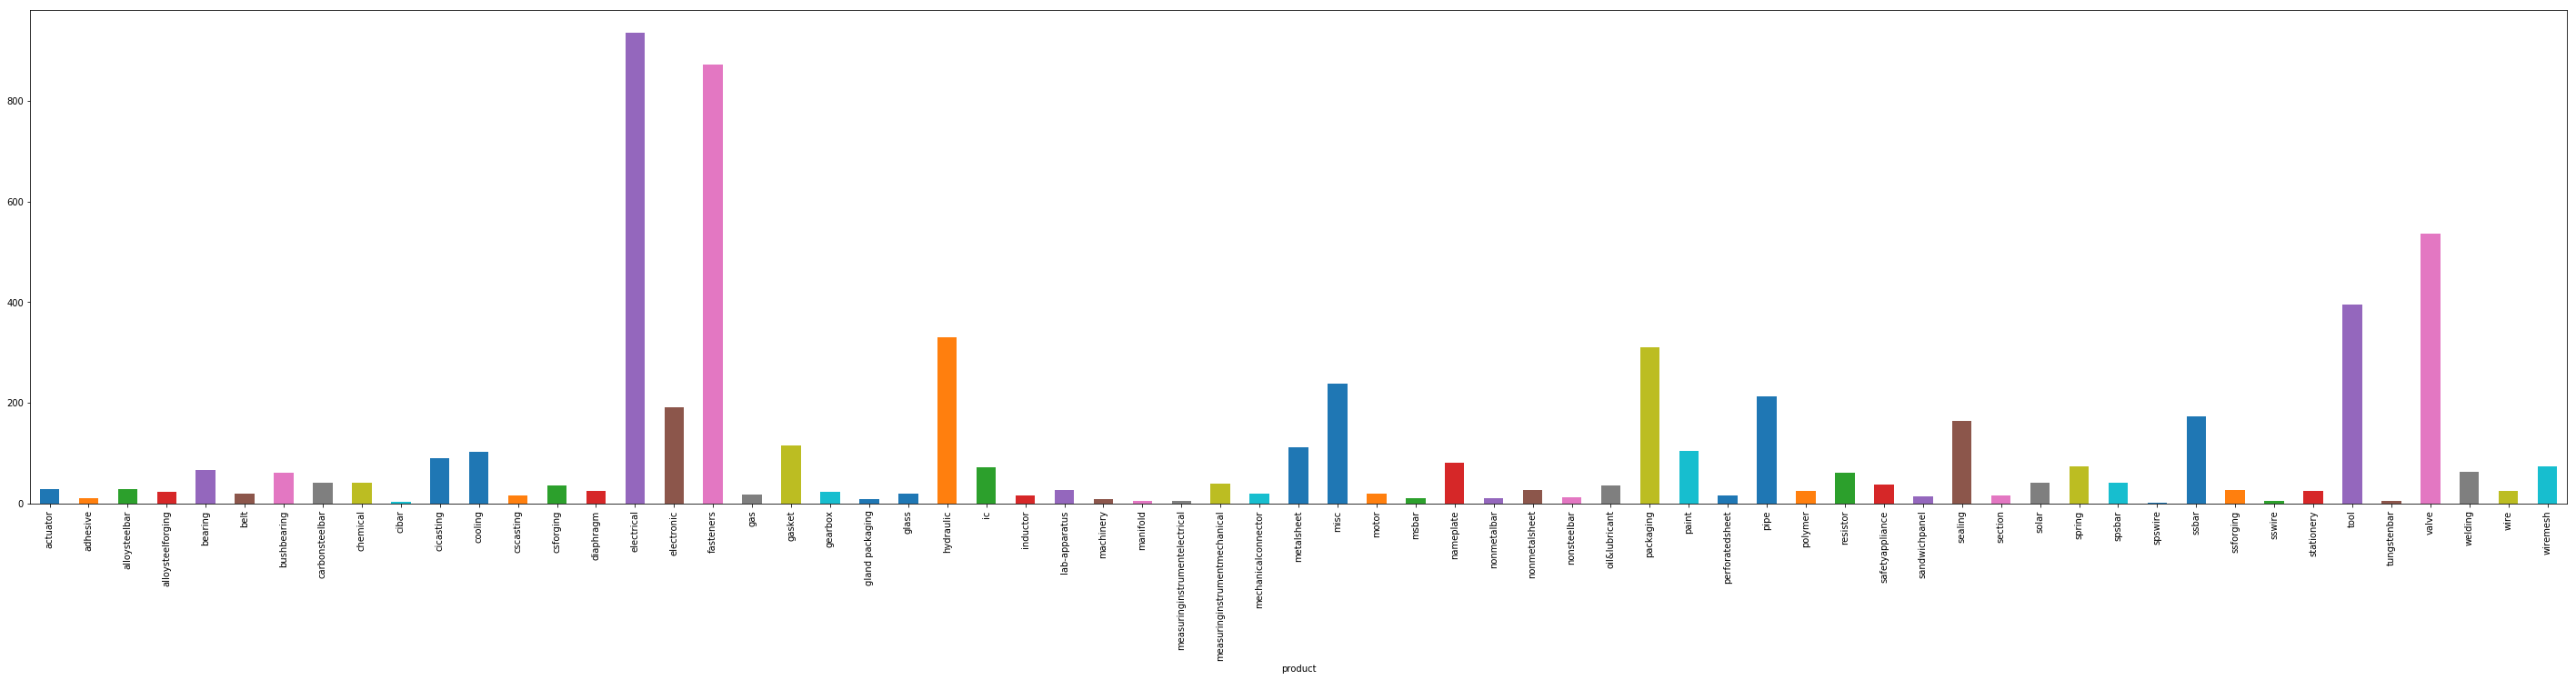

In [9]:
# digitising 'product' and creating a dictionary for labelled data:

tranzact_data_labelled['product_id'] = tranzact_data_labelled['product'].factorize()[0]

product_id_df = tranzact_data_labelled[['product', 'product_id']].drop_duplicates().sort_values('product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['product_id', 'product']].values)

num_labells = max(tranzact_data_labelled['product_id']) + 1  ## required for keras last layer dimension

## To show distribution of product category

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(50,10))
print(max(tranzact_data_labelled.groupby('product').item.count()))
tranzact_data_labelled.groupby('product').item.count().plot.bar(ylim=0)
plt.show()

## Pl. note the unbalance distribution of product categories. In category Fasteners, there are 1736 items(maxm no.)

In [10]:
## Gives the product wise item distribution. In some product categories there are only 1 item.
from collections import Counter
Counter(tranzact_data_labelled["product"])

Counter({'actuator': 29,
         'adhesive': 12,
         'alloysteelbar': 30,
         'alloysteelforging': 23,
         'bearing': 67,
         'belt': 21,
         'bushbearing': 61,
         'carbonsteelbar': 41,
         'chemical': 41,
         'cibar': 4,
         'cicasting': 91,
         'cooling': 104,
         'cscasting': 17,
         'csforging': 37,
         'diaphragm': 26,
         'electrical': 934,
         'electronic': 191,
         'fasteners': 872,
         'gas': 19,
         'gasket': 116,
         'gearbox': 24,
         'gland packaging': 10,
         'glass': 21,
         'hydraulic': 330,
         'ic': 73,
         'inductor': 16,
         'lab-apparatus': 28,
         'machinery': 9,
         'manifold': 6,
         'measuringinstrumentelectrical': 6,
         'measuringinstrumentmechanical': 40,
         'mechanicalconnector': 21,
         'metalsheet': 113,
         'misc': 238,
         'motor': 21,
         'msbar': 11,
         'nameplate': 82,
     

In [12]:
from gensim.models import Word2Vec
from tqdm import tqdm

temp_corpus_labelled = tranzact_data_labelled['item'].map(lambda x: x.split('.'))

corpus_labelled = []
for i in tqdm(range(len(temp_corpus_labelled))):
    for line in temp_corpus_labelled[i]:
        words = [x for x in line.split()]
        corpus_labelled.append(words)
        
## No. of labelled items, no. of total words in labelled items, max_length of longest labelled item :
        
num_of_items_labelled = len(corpus_labelled)

num_of_words_labelled = 0
for line in corpus_labelled:
    num_of_words_labelled += len(line)
    
max_length_labelled = 0
for i in range(len(corpus_labelled)):
    max_length_labelled  = max(max_length_labelled, len(corpus_labelled[i]), len(corpus_labelled[i+1]))
    if i == len(corpus_labelled)-2:
        break
        
print('Num of labelled items - %s'%(num_of_items_labelled))
print('Num of words in labelled items - %s'%(num_of_words_labelled))
print('Max no. of words in longest labelled-item-description - %s'%(max_length_labelled))

## items to word2vec :

emb_dim = 150

model_1 = Word2Vec(corpus_labelled, size = emb_dim, window=2, \
               min_count=1, negative = 10, iter = 10, workers = 10, sg=1)

print(model_1)

100%|██████████| 6334/6334 [00:00<00:00, 46400.05it/s]


Num of labelled items - 6334
Num of words in labelled items - 29965
Max no. of words in longest labelled-item-description - 31
Word2Vec(vocab=4820, size=150, alpha=0.025)


In [13]:
## Creating X and y variables for training. X = Items or item 'feature'. y = 'product' or product category

X = []
for i in range(tranzact_data_labelled.shape[0]):
    X.append(tranzact_data_labelled.iloc[i][1])
y = tranzact_data_labelled["product"]

print(X[0])


new cylinder gas


In [14]:
tokenizer_obj_lab = Tokenizer()
tokenizer_obj_lab.fit_on_texts(tranzact_data_labelled['item'])
tokenizer_obj_lab_index = tokenizer_obj_lab.word_index
max_length_lab = max([len(s.split()) for s in tranzact_data_labelled['item']])
vocab_size_lab = len(tokenizer_obj_lab.word_index) + 1

In [16]:
X_tokens = tokenizer_obj_lab.texts_to_sequences(X)
X_pad = pad_sequences(X_tokens, maxlen = max_length_labelled, padding = 'post')

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()

Y_coded = encoder.fit_transform(y)

print(Y_coded.shape)

print(X_pad[0])

(6334, 65)
[779  99 461   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [17]:
## prepare embedding matrix :

embedding_matrix = np.zeros((vocab_size_lab, emb_dim))

for word, i in tokenizer_obj_lab_index.items():
    
    emb_vector = model_1.wv.word_vec(word)
    
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))




Null word embeddings: 1


In [19]:
## The model

from keras.models import Sequential

model_3 = Sequential()
model_3.add(Embedding(vocab_size_lab, emb_dim, weights=[embedding_matrix],\
                    input_length=max_length_labelled, trainable=True))
model_3.add(SpatialDropout1D(0.2))
#model_3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh'))
#model_3.add(MaxPooling1D(pool_size=2))

#model_3.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
#model_3.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
#model_3.add(Bidirectional(GRU(units=128, dropout=0.2, recurrent_dropout=0.2)))
model_3.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model_3.add(Dense(256, activation='tanh'))
model_3.add(Dense(num_labells, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 150)           723150    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 31, 150)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               285696    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 65)                16705     
Total params: 1,091,343
Trainable params: 1,091,343
Non-trainable params: 0
_________________________________________________________________


In [20]:
#train test split in 80% / 20% ratio

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, Y_coded, test_size=0.20, random_state=5)


In [21]:
model_3.fit(X_train,y_train,batch_size=64,epochs=30,
          validation_split=0.2)

Train on 4053 samples, validate on 1014 samples
Epoch 1/30
4053/4053 [==============================] - 12s 3ms/step - loss: 2.9674 - acc: 0.3003 - val_loss: 2.4201 - val_acc: 0.3955
Epoch 2/30
4053/4053 [==============================] - 10s 2ms/step - loss: 2.0994 - acc: 0.4685 - val_loss: 1.7839 - val_acc: 0.5690
Epoch 3/30
4053/4053 [==============================] - 10s 2ms/step - loss: 1.4775 - acc: 0.6146 - val_loss: 1.3482 - val_acc: 0.6410
Epoch 4/30
4053/4053 [==============================] - 12s 3ms/step - loss: 1.0231 - acc: 0.7350 - val_loss: 1.0495 - val_acc: 0.7426
Epoch 5/30
4053/4053 [==============================] - 9s 2ms/step - loss: 0.7357 - acc: 0.8159 - val_loss: 0.9120 - val_acc: 0.7712
Epoch 6/30
4053/4053 [==============================] - 9s 2ms/step - loss: 0.5320 - acc: 0.8655 - val_loss: 0.7702 - val_acc: 0.8126
Epoch 7/30
4053/4053 [==============================] - 9s 2ms/step - loss: 0.3783 - acc: 0.9025 - val_loss: 0.7184 - val_acc: 0.8146
Epoch 8/30

In [22]:
X_test_tokens = []

for i in range(len(X_test)):
    X_test_tokens.append((X_test[i][X_test[i] != 0]).tolist())

X_test_text = tokenizer_obj_lab.sequences_to_texts(X_test_tokens)

X_test_text_df = pd.DataFrame()
X_test_text_df = pd.DataFrame(X_test_text)
X_test_text_df.columns = ['items']
X_test_text_df.head()


,items
0,high speed cutter c211 r a
1,fully automatic washing machine white magic cl...
2,suction strainer
3,contactor v
4,marina lts jug fluted monobox


In [33]:
df_original_label = pd.DataFrame()
df_predicted_label = pd.DataFrame()

df_original_label = pd.DataFrame(encoder.inverse_transform(y_test))
df_original_label.columns = ['product_original']

df_predicted_label = pd.DataFrame(encoder.inverse_transform(model_3.predict(X_test)))
df_predicted_label.columns = ['product_pred']


df_label_compare = pd.concat([X_test_text_df, df_original_label, df_predicted_label], axis=1)
df_label_compare.columns = ['item', 'product', 'prediction']


df_label_unmatched = df_label_compare[df_label_compare['prediction'] != df_label_compare['product']]
df_label_unmatched.to_excel(r'/home/scar3crow/Downloads/accu_check_2.xlsx')

df_label_unmatched.head(10)

,item,product,prediction
22,plastic hot air fusion welding machine mfr wel...,welding,tool
26,pp sheet mikky white,nonmetalsheet,welding
30,automotive components state push connector,hydraulic,electrical
39,hole saw,tool,electrical
58,transperant cello tape,stationery,electrical
66,consumables grease,oil&lubricant,hydraulic
69,osc motortpw,motor,misc
70,preset square,electrical,tool
71,transparent tape,stationery,sealing
74,en19 rod,alloysteelbar,wire


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

model_accuracy = accuracy_score(df_predicted_label['product_pred_1'], df_original_label['product_original'])

models_accuracy = f1_score(df_predicted_label['product_pred_1'], df_original_label['product_original'], average='weighted')

print(model_accuracy)

print(models_accuracy)


0.856353591160221
0.8623730431372122


In [40]:
## Input Item name here in the syntax given below :

Search_Item = 'color packet'

Input_Item_Name = [Search_Item]

Input_tokens = tokenizer_obj_lab.texts_to_sequences(Input_Item_Name)
Input_pad = pad_sequences(Input_tokens, maxlen = max_length_labelled, padding = 'post')

## Find product category here :
Output_Product_Category = encoder.inverse_transform(model_3.predict(Input_pad))

if len(Input_tokens[0]) == 0:
    print('There are no such items in our data base')
else:
    print('Product Category = ', Output_Product_Category)

output_cat_list = Output_Product_Category.tolist()



Product Category =  ['electrical']


In [138]:
## creating data search file of all items of same category :

tranzact_data_search = tranzact_data_labelled.loc[tranzact_data_labelled['product'] \
                                                               == output_cat_list[0]]

tranzact_data_search = tranzact_data_search.reset_index(drop=True)

## Creating test vector from Text features :

from sklearn.feature_extraction.text import TfidfVectorizer

my_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', ngram_range=(1, 2), use_idf = True)


merge_text_feature = []
merge_text_feature_digit = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_search['item'].append(pd.Series(Input_Item_Name))

merge_text_feature = merge_text_feature.reset_index(drop=True)

merge_text_feature_digit = my_vectorizer.fit(merge_text_feature)

# encode document
merge_digit_vector = merge_text_feature_digit.transform(merge_text_feature).toarray()


test_digit_vector = merge_digit_vector[len(merge_digit_vector)-1].reshape((merge_digit_vector.shape)[1],)

merge_digit_vector_1 = merge_digit_vector[0:(len(merge_digit_vector)-1)]

## Cosine Similarity :

import scipy

def cos_cdist(matrix, vector):
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

## Finding cosine similarity & picking 50 top similar lines :

c_d = []

c_d = np.round((1 - cos_cdist(merge_digit_vector_1, test_digit_vector)), 3)

max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]

## Finding suppliers :

result = []
result_frame = []

for i in max_c_s_index:
    
    result.append(np.array([c_d[i], tranzact_data_search['item'][i], tranzact_data_search['supplier'][i]]))

result_frame = pd.DataFrame(result, columns=['c_index', 'item', 'supplier'])

result_frame.c_index = result_frame.c_index.astype('float64')

result_frame.drop_duplicates(subset='supplier', keep = 'first', inplace = True)
result_frame = result_frame.reset_index(drop=True)

kount = 0

for i in range(len(result_frame['supplier'])):
    if result_frame['c_index'][i] > 0:
        print(result_frame['supplier'][i])
        kount = kount+1
        if kount == 4 :
            break
result_frame.head(10)


m/s. s. k. enterprise
v ramp automation
sun shine electronics
vashi electricals pvt. ltd


,c_index,item,supplier
0,1.000,ceramic insulator,m/s. s. k. enterprise
1,0.284,insulator v2 v,v ramp automation
2,0.241,capacitor smd ceramic,sun shine electronics
3,0.205,c round insulator dmc,vashi electricals pvt. ltd
4,0.113,multilayer ceramic capacitors mlcc package smd...,gujarat poly electronics ltd
5,0.113,multilayer ceramic capacitors mlcc smd smt mfr...,mouser electronics inc.
6,0.112,multilayer ceramic capacitors mlcc smd smt mfr...,evelta electronics private limited
7,0.104,multilayer ceramic capacitors mlcc package smd...,sun micro components pvt ltd
8,0.000,downrod pearl ivory v,arihant sales corporation
9,0.000,tpwdiode red led through hole pitch,millennium semiconductors


In [141]:
tranzact_data_labelled.groupby('product')

In [41]:
#tranzact_data_cesare_international_1 = tranzact_data_2.loc[tranzact_data_2['OEM'] \
#                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']


tranzact_data_labelled_electrical = tranzact_data_labelled.loc[tranzact_data_labelled['product'] \
                                                               == 'electrical']
tranzact_data_labelled_electrical.to_excel(r'/home/scar3crow/Downloads/electrical.xlsx')

In [145]:
tranzact_data_labelled_electrical.head(10)

,OEM,item,product,supplier,find_duplicate,product_id
185,Truefit Engineering Company Limited,cable tie,electrical,goldlink technocast,cable tie 6 inchgoldlink technocast,18
394,LE Electronics Pvt Ltd,way bar graph red face greay,electrical,alpesh metals,10 way bar graph (red) (face: greay)alpesh metals,18
434,LE Electronics Pvt Ltd,led bar red lb714sr,electrical,max forge,led bar 14 x 7.5 red (lb714sr)max forge,18
504,Atomberg Technologies Private Limited,batteries eveready,electrical,n m automation and control private limited,batteries evereadyn m automation and control p...,18
505,GREENWAY GRAMEEN INFRA PVT LTD,battery,electrical,superb auto batteries,batterysuperb auto batteries,18
506,LE Electronics Pvt Ltd,battery cr2032,electrical,superb auto batteries,battery cr2032 (3v)superb auto batteries,18
507,Polfrost Air Con Pvt Ltd.,accessory battery rtc,electrical,micromatic machine tools pvt. ltd.,accessory.m200 battery for rtcmicromatic machi...,18
508,Entech Controls,fanuc battery n,electrical,naviya technologies,fanuc battery 6v (n)naviya technologies,18
509,Accuster Technologies Pvt Ltd,battery v,electrical,shree durga battery & auto parts,battery 12 v 7.2 ahshree durga battery & auto ...,18
510,Accuster Technologies Pvt Ltd,gold battery,electrical,jyoti motors,gold batteryjyoti motors,18
